# Twitter Sentiment Analysis

1. Build the model
2. Extract features from Twitter
3. Run the classifier

## Build model

In [1]:
import pandas as pd
import numpy as np
import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
from tweepy import OAuthHandler
import json
import os



In [20]:
data = pd.read_csv(os.path.join("../..","data",'twitter-training-data','Sentiment Analysis Dataset.csv'))

/Users/mchivuku/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
print(data.shape) 
print(data.columns)

(1048574, 7)
Index(['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6'],
      dtype='object')


1    554470
0    494104
Name: Sentiment, dtype: int64


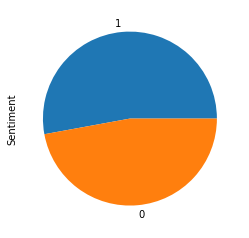

In [31]:
##target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
data["Sentiment"].value_counts().plot.pie()

data = data.loc[:,["Sentiment","SentimentText"]]
print(data["Sentiment"].value_counts())

In [41]:
from sklearn.utils import shuffle
data = shuffle(data)

X_train, X_test, y_train, y_test = train_test_split(data['SentimentText'], data['Sentiment'], test_size=0.2,random_state=42, shuffle=True)


In [42]:
print("No of train,", len(X_train),"No of test",len(X_test))

No of train, 838859 No of test 209715


In [43]:
y_train.value_counts()

1    443698
0    395161
Name: Sentiment, dtype: int64

In [44]:
## Create pipeline for the model
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [46]:
## Grid search for parameters.

parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }


# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 45.6min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bow__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'classifier__alpha': (0.01, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [48]:
## Save the model
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

In [49]:
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)


In [50]:
print("Accuracy score",accuracy_score(y_test,y_preds))

Accuracy score 0.7485635266909854


In [67]:
# get predictions from best model above

# test string
sample_str = "awesome"
model_NB.predict([sample_str])

array([1])